![](../images/rivacon_frontmark_combined_header.png)

# Discount Curves

In [ ]:
import datetime as dt
from rivapy.marketdata.curves import DiscountCurve

import math
import pandas as pd
%load_ext autoreload
%autoreload 2
#the next lin is a jupyter internal command to show the matplotlib graphs within the notebook
%matplotlib inline

In [ ]:
import pyvacon

In [ ]:
pyvacon.

## Definition of Discount Curves
A discount curve 
- stores discount factors for different maturities,
- has an interpolation to compute discount factors for arbitrary maturities,
- has an extrapolation to compute discount factors for arbitrary maturities after the latest given maturity,
- has a day counter to convert dates to year fractions to apply the inter- and extrapolation.

Under the assumption of continuous compounding, the discount factor $df$ for a cashflow at maturity $T$ based on a constant discount rate $r$ is defined as

$$df(T) = e^{-rT}$$

where $T$ is the time to maturity as year fraction.


## Creating Discount Curves
### Setup the specification

To setup a discount curve, we need the following information:



**Object id**

Nearly every structure in the analytics library has an object id. An object id allows for nice logging and exceptions (which object created the message/error) and is also used as identifier for retrieving objects from containers.

In [7]:
object_id = "Test_DC"

**Reference date**

A reference date is needed for all objects representing market data. Dates entering analytics objects must be analytics ptimes. 

Most of the functions provided by market data objects also get a calculation/valuation date and some logic is applied if this date is after the reference date. For a discount curve, if the valuation date is after the reference date, the forward discount factor is returned.

The help function provides information about the function mentioned in its arguments (in parentheses). Uncomment the line to see the information about the analytics.ptime function.

In [8]:
refdate = dt.datetime(2017,1,1,0,0,0)

**Dates and corresponding discount factors**

We need a list of dates and a list of discount factors. Here, we must use the analytics (C++ swigged) vectors to create the list of dates. We use a helper method which just gets a list of number of days and a reference date and returns the resulting dates from adding the number of days to the reference date. To view the created list of dates, uncomment the 4th and 5th line of the following code.

To calculate the discount factors from a constant rate, we need to provide the constant rate and calculate the discount factors according to the desired compounding frequency.

In [9]:
days_to_maturity =  [1, 180, 365, 720, 3*365, 4*365, 10*365]
dates = [refdate + dt.timedelta(days=i) for i in days_to_maturity]
discount_rate = 0.03
df = [math.exp(-d/365.0*discount_rate) for d in days_to_maturity]

**Day count convention**

Additionally, we need to provide the discount curve with a day count convention. The different options are provided in the enums module. Here, we apply the ACT365FIXED day count convention where the number of days between two dates is divided by 365. For other examples please refer to the [Roll conventions, day counters and schedule generation](daycounter_rollconventions_schedules.ipynb) notebook.

**Interpolation type and extrapolation type**

The interpolation is necessary to compute discount factors for arbitrary maturities until the last maturity provided; the extrapolation is necessary to compute discount factors for arbitrary maturities after the last given maturity. Here, we use HAGAN_DF as interpolation type and use no extrapolation. For an overview of interpolation and extrapolation types please refer to the *enums* module.

The main advantage of the The HAGAN_DF interpolation, also called the monotone convex method (unameliorated version), is that in contrast to the other methods, it ensures forward rates to be positive and is, hence, the probably most suitable interpolation method for financial problems. The method is described in depth in: Hagan, West, "Methods for Constructing a Yield Curve", 2008.

The following diagrams show the differences between the linear and HAGAN_DF interpolation for a newly created discount curve.

In [23]:
refdate = dt.datetime(2017,1,1,0,0,0)
days_to_maturity =  [1, 180, 365, 720, 3*365, 4*365, 10*365]
rates = [-0.0065, 0.0003, 0.0059, 0.0086, 0.0101, 0.012, 0.02]
dates = [refdate + dt.timedelta(days=i) for i in days_to_maturity]
dsc_fac = [math.exp(-rates[d]*days_to_maturity[d]/365) for d in range(len(rates))]
        
dc_linear = DiscountCurve('dc_linear', refdate, dates, dsc_fac, enums.InterpolationType.LINEAR)
dc_hagan = DiscountCurve('dc_hagan', refdate, dates, dsc_fac, enums.InterpolationType.HAGAN_DF)


dc_linear.plot()
dc_hagan.plot()
plt.legend()

AttributeError: 'DiscountCurve' object has no attribute 'plot'

In [15]:
dc_linear.plot()

AttributeError: 'DiscountCurve' object has no attribute 'plot'

### Setup the discount curve

Our discount curve is given the name *dc* and is defined as an analytics.DiscountCurve object which we provide with the information described before. 

In [7]:
dc = analytics.DiscountCurve(object_id, refdate,dates, df, enums.DayCounter.ACT365_FIXED, enums.InterpolationType.HAGAN_DF, enums.ExtrapolationType.NONE)
#help(analytics.DiscountCurve)

## Compute Discount Factors

This section is only to manually derive some discount factors from the recently created discount curve.

**a. Maturity in 180 days from the reference date**

The value function returning a discount factor needs two arguments: the calculation date (here we use the current reference date) and the maturity for which the discount factor shall be computed. Hence, in a first step, the maturity in 180 days has to be converted into a date. Subsequently, the discount factor is computed using the value function. Finally, the print function gives us the computed discount factor of the value function.

In [8]:
maturity = converter.getLTime(180, refdate)
#help(converter.getLTime)
#print(maturity.to_string())
df1 = dc.value(refdate, maturity)
#help(dc.value)
print("DF for T=180 days: ", df1)

DF for T=180 days:  0.9853143806656076


**b. Forward discount factor for a maturity in 180 days in 90 days**

If the valuation date given is in the future, the value function returns the forward discount factor. The following example gives us the forward discount factor for a maturity in 180 days in 90 days.

In [9]:
fwd_df = dc.value(converter.getLTime(90, refdate), maturity)
print("Fwd-DF for T=180 days in 90 days: ", fwd_df)

Fwd-DF for T=180 days in 90 days:  0.9926300321180352


A check proves that the result equally the forward discount curve.

In [10]:
df2 = dc.value(refdate, converter.getLTime(90, refdate))
print("Fwd-DF (manual calculation): ", df1/df2)

Fwd-DF (manual calculation):  0.9926300321180352


**c. Valuation dates before the reference date**

Valuation dates before the curves reference date result in an exception (uncomment the following code to see the exception).

In [11]:
#dc.value(converter.getLTime(-90, refdate), maturity)

**d. Vector of discount factors** 

There is also a version of the value function to compute a whole vector of discount factors which may be more efficient then looping over the method returning one value. For simplification we just use the dates vector from the construction.

In [12]:
dfs = analytics.vectorDouble()
dc.value(dfs, refdate, dates)
print("Vector of DFs:")
for df in dfs: print(df)

Vector of DFs:
0.9999178115998296
0.9853143806656076
0.9704455335514195
0.9425389048195377
0.91393118527397
0.8869204367198182
0.7408182206861628


To see the two versions of the value function and the arguments required uncomment the following code.

In [13]:
#help(analytics.DiscountCurve.value)

## Plotting Discount Curves

To plot a curve one needs to pass the dates (either as a vector or list of datetime/ptimes or as a list of days from the reference date), where the curve will be evaluated and the reference date.

In addition, one can choose if the discount factors or continuously compounded rates will be plotted. To show the second option, we first create a new figure, otherwise the rate will be plotted in the same figure as the discount factors.

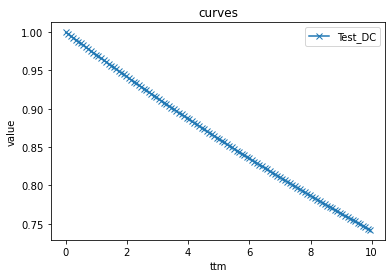

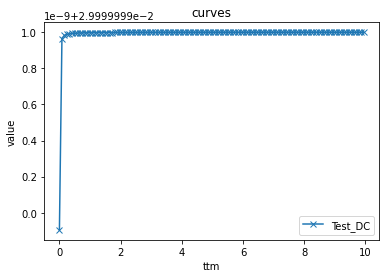

In [14]:
#help(mkt_plot.curve)
mkt_plot.curve(dc,range(1,10*365,30), refdate)
mkt_plot.plt.figure()
mkt_plot.curve(dc,range(1,10*365,30), refdate, True)

## Exercises

- Create a second discount curve with non-flat rate structure.

- Plot the second discount curve and the first discount curve together in one figure.

- Create a third discount curve exactly as the second but with interpolation LINEARLOG and compare the differences of results using different interpolation schemes (note that finding the correct ensemble of dates and discount factors, forward rates may not be smoothly interpolated with LINEARLOG).

- Write a function computing a simply (continuously) compounded rate for a given discount factor and year fraction.

- Write a function computing an annually compounded rate for a given discount factor and year fraction.

- Find and modify the plot function from above so that the user can additionally choose which compounding rate is used when plotting the rate.

---